In [1]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [2]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# Iniciar Data frame
df = append_dataframes()

Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [5]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [6]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

In [7]:
# Limpiamos n_rooms y n_baths, sujeto a cambios
#df['n_rooms'] = df['n_rooms'].replace('5+', 6)
#df['n_rooms'].fillna(3, inplace=True)


def transforma_int(num):
    if num == np.nan:
        return num
    elif num == 'nan':
        return np.nan
    elif num == '5+':
        return num
    else:
        return str(float(num))


df['n_rooms'] = df['n_rooms'].apply(transforma_int)

#df['n_bath'] = df['n_bath'].replace('5+', 6)
#df['n_bath'].fillna(3, inplace=True)
df['n_bath'] = df['n_bath'].apply(transforma_int)

Vemos los Dtype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   property_type|rent_type|location  16379 non-null  object  
 1   price                             16379 non-null  float64 
 2   n_rooms                           16379 non-null  object  
 3   n_bath                            16379 non-null  object  
 4   surface                           16379 non-null  float64 
 5   details                           16269 non-null  object  
 6   url                               16379 non-null  object  
 7   metro_cuadrado                    16379 non-null  float64 
 8   _merge                            16379 non-null  category
dtypes: category(1), float64(3), object(5)
memory usage: 1.0+ MB


In [9]:
df['n_rooms'].unique()

array(['3.0', '5.0', '4.0', '2.0', '1.0', 'nan', '5+'], dtype=object)

##### b)

In [10]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']
   ] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type', 'rent_type']
   ] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location',
              'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [11]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [12]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return '0'
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return str(n)


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [13]:
# Limpiamos n_garajes, sujeto a cambios
#df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(str)

In [14]:
df['n_garajes'].unique()

array(['1', '0', '2', '4', '3', '4+'], dtype=object)

### 4- . Clasificación por tipo de producto

In [15]:
# Inicializamos la columna tipo
df['tipo'] = np.nan


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(
                minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = str(tipo_prod)
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(
                minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = str(tipo_prod)

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [16]:
df

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1,NaN
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,47887.323944,0,NaN
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only,BALCONES DE ORIENTE Bogotá D.C..,Casa,Arriendo,16250.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16374,2600000.0,1.0,2.0,60.0,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,right_only,SANTA BIBIANA Bogotá D.C..,Apartamento,Arriendo,43333.333333,1,NaN
16375,2350000.0,1.0,1.0,43.0,CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,right_only,SANTA BARBARA OCCIDENTAL Bogotá D.C..,Apartamento,Arriendo,54651.162791,1,6
16376,1750000.0,1.0,1.0,48.0,Apartamentototalmente amoblado de 47 metros c...,https://www.metrocuadrado.com/inmueble/arriend...,39.4,right_only,CHICO NORTE Bogotá D.C..,Apartamento,Arriendo,36458.333333,1,6
16377,3900000.0,2.0,3.0,102.0,Hermoso y acogedor apartamento completamente a...,https://www.metrocuadrado.com/inmueble/arriend...,51.6,right_only,LA CABRERA Bogotá D.C..,Apartamento,Arriendo,38235.294118,2,8


In [17]:
df['tipo'].unique()

array([nan, '1', '2', '3', '4', '5', '6', '7', '8'], dtype=object)

### 5- .

In [18]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [19]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)
upz

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,PALERMO
1,UPZ100,1,GALERIAS,2.375681e+06,BELALCAZAR
2,UPZ100,1,GALERIAS,2.375681e+06,SEARS
3,UPZ100,1,GALERIAS,2.375681e+06,GALERIAS
4,UPZ100,1,GALERIAS,2.375681e+06,BANCO CENTRAL
...,...,...,...,...,...
463,UPZ42,1,VENECIA,6.638420e+06,NUEVO MUZU
464,UPZ42,1,VENECIA,6.638420e+06,EL CONDOR
465,UPZ42,1,VENECIA,6.638420e+06,LAGUNETA
466,UPZ52,1,LA FLORA,1.877160e+06,VILLA MARIA


In [20]:
# Inicializamos la columna
df['upz'] = np.nan
df['UPlArea'] = np.nan


def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    upl_area = list(upz['UPlArea'])
    codigos_upl = list(upz['UPlCodigo'])

    for area, codigo, locacion in zip(upl_area, codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index

        for i in indice:
            df.loc[i, 'upz'] = codigo
            df.loc[i, 'UPlArea'] = area

    return df


df = clasifica_upz(df)

In [21]:
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo,upz,UPlArea
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1,NaN,UPZ101,2.357008e+06
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1,1,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0,1,UPZ75,4.964574e+06


In [22]:
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'].notna()])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [23]:
est_poblacion = pd.read_csv(
    './data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns=['Unnamed: 0', 'nomupz'], inplace=True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [24]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on='upz', how='left')

In [25]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns={'UPlCodigo': 'upz'})
ind_inseg.drop(columns=['UPlNombre2', 'Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [26]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on='upz', how='left')

In [27]:
per_areas_verdes = pd.read_csv(
    './data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [28]:
per_areas_verdes.rename(
    columns={'upz': 'zona', 'cod_upz': 'upz'}, inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'], inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [29]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on='upz', how='left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [30]:
# Enriquecemos df con la densidad de población por UPZ
df['dens_upz'] = df['personas']/df['UPlArea']

In [31]:
df.replace(np.inf, np.nan, inplace=True)
df.replace(-np.inf, np.nan, inplace=True)
df['_merge'] = df['_merge'].astype(str)
# df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price                                    16381 non-null  float64
 1   n_rooms                                  16381 non-null  object 
 2   n_bath                                   16381 non-null  object 
 3   surface                                  16381 non-null  float64
 4   details                                  16271 non-null  object 
 5   url                                      16381 non-null  object 
 6   metro_cuadrado                           16381 non-null  float64
 7   _merge                                   16381 non-null  object 
 8   location                                 16381 non-null  object 
 9   property_type                            16381 non-null  object 
 10  rent_type                                16381

In [34]:
# Copia para correr P2
copia = df.copy()

# P2

In [36]:
df = copia

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

## Parte 1

In [38]:
def estilo():
    sns.set_style('dark')
    sns.despine()

In [39]:
estilo()

<Figure size 432x288 with 0 Axes>

## Parte 2

In [40]:
names = ['numeric', 'categorical', 'resto']
# Se crea una lista con las columnas numericas
numeric = ['price', 'surface', 'metro_cuadrado', 'precio_m2',
           'UPlArea', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
           'trabajoinfampliado_ninos_5_17_anos_perc',
           'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
           'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
           'areas_verdes_perc', 'dens_upz'
           ]

# datos no categoricos ni numerico
resto = ['details','zona', 'location','url']

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric) - set(resto))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

In [41]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

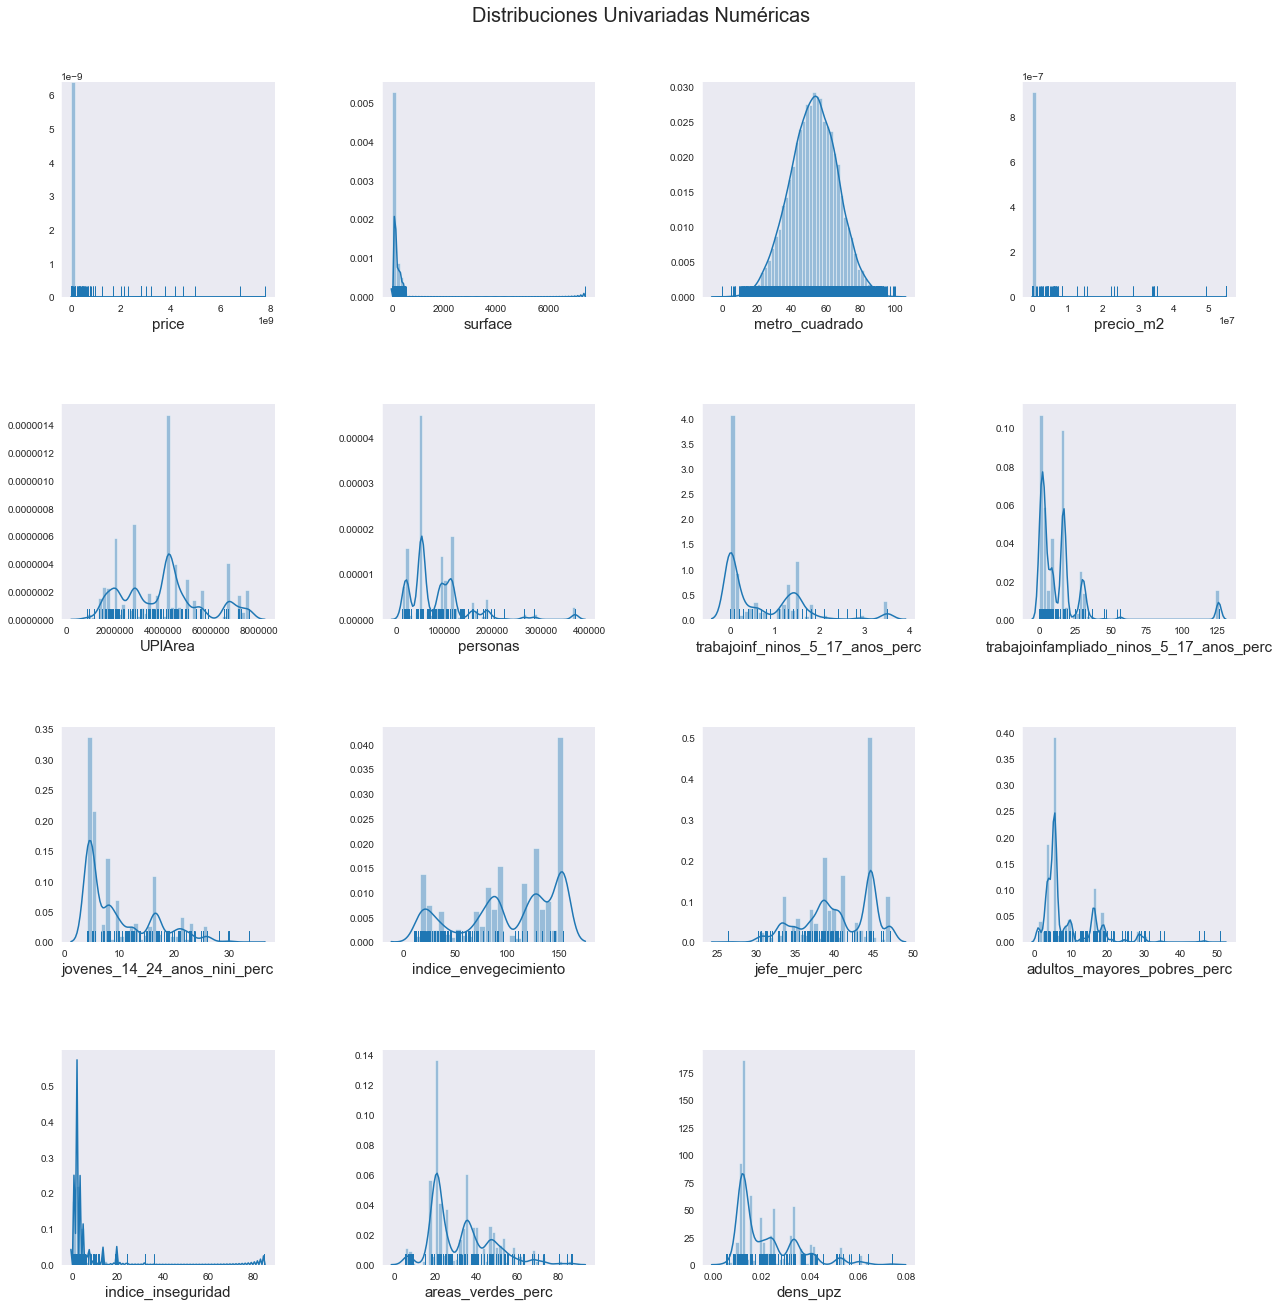

In [42]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a: a.remove(), ax[-1, -1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    # print(col)
    try:
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)

    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(),
                     ax=axis, rug=True, kde=False)

    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

La variable metro_cuadrado es de gran interés por su normalidad. precio y precio_m2 tienen gran cantidad de outliers que empeora su perfilamiento.

In [43]:
# Notemos que hay ciertas variables que al considerar menos datos, mejora la densidad
num_antes = len(df)
#df = df[df[('numeric','surface')] <= 4 * 10**3]
#df = df[df[('numeric','precio_m2')] <= 2 * 10**5]
df = df[df[('numeric','surface')] <= 10000]
df = df[df[('numeric','precio_m2')] <= 100000]
#df = df[df[('numeric','indice_inseguridad')] <= 80]
df.reset_index(drop=True, inplace = True)
num_despues = len(df)
print('Se dropearon',num_antes-num_despues,'elementos')

Se dropearon 100 elementos


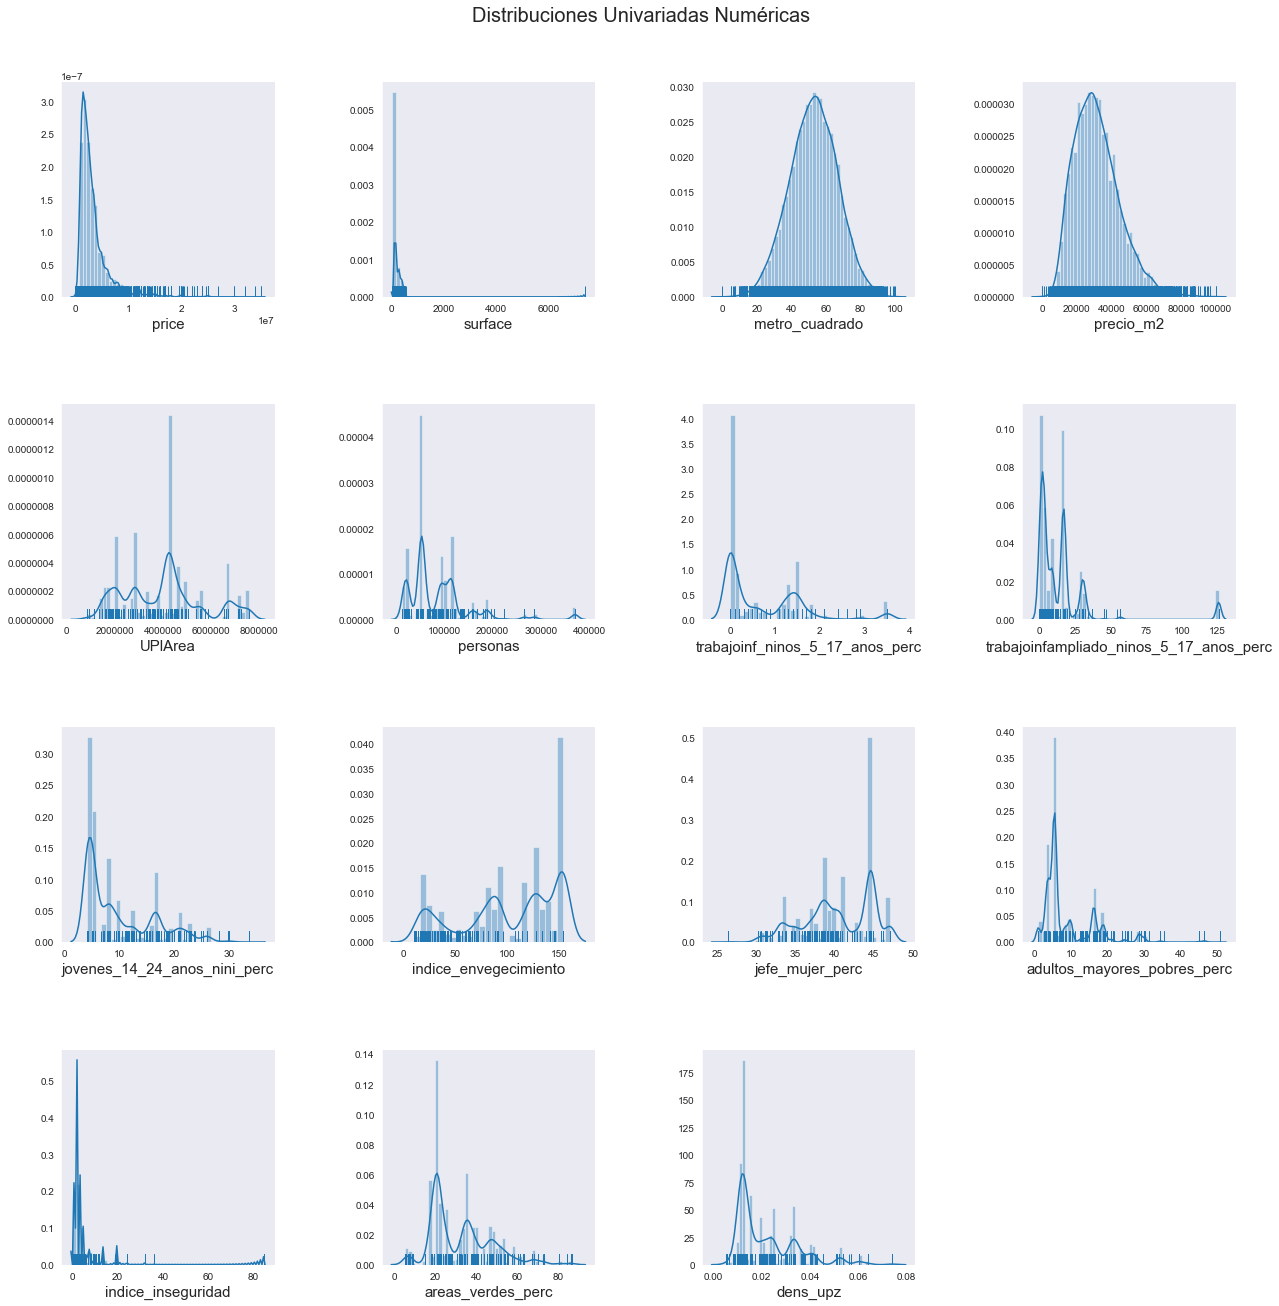

In [44]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a: a.remove(), ax[-1, -1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    # print(col)
    try:
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)

    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(),
                     ax=axis, rug=True, kde=False)

    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

In [45]:
# Datos faltantes
import missingno as msno
#df.replace('nan', np.nan, inplace=True)
print('Valores nan')
print(df.isnull().sum())
print('Mayor info perdida')
print(df.isnull().sum().nlargest(10))

Valores nan
numeric      price                                         0
             surface                                       0
             metro_cuadrado                                0
             precio_m2                                     0
             UPlArea                                    1325
             personas                                   1325
             trabajoinf_ninos_5_17_anos_perc            1325
             trabajoinfampliado_ninos_5_17_anos_perc    1325
             jovenes_14_24_anos_nini_perc               1325
             indice_envegecimiento                      1325
             jefe_mujer_perc                            1325
             adultos_mayores_pobres_perc                1325
             indice_inseguridad                         1325
             areas_verdes_perc                          1325
             dens_upz                                   1325
categorical  _merge                                        0
            

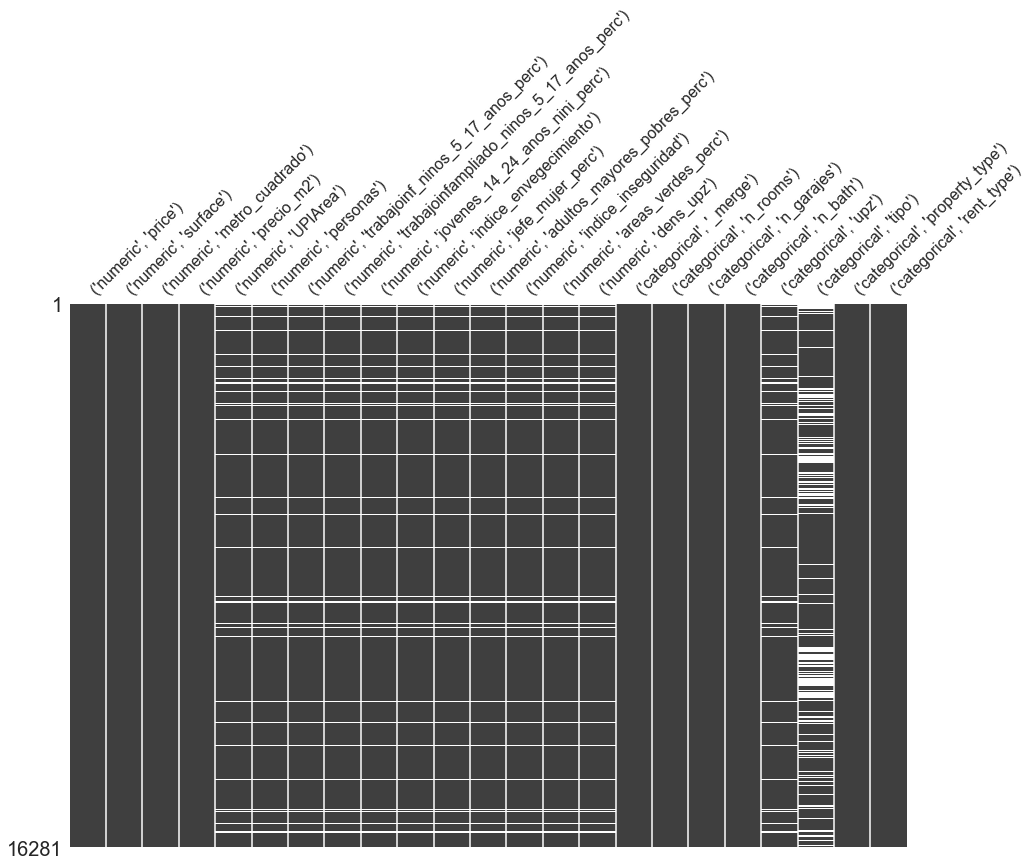

In [46]:
fig, ax = plt.subplots(figsize=[15, 10])
msno.matrix(df, ax=ax, sparkline=False)

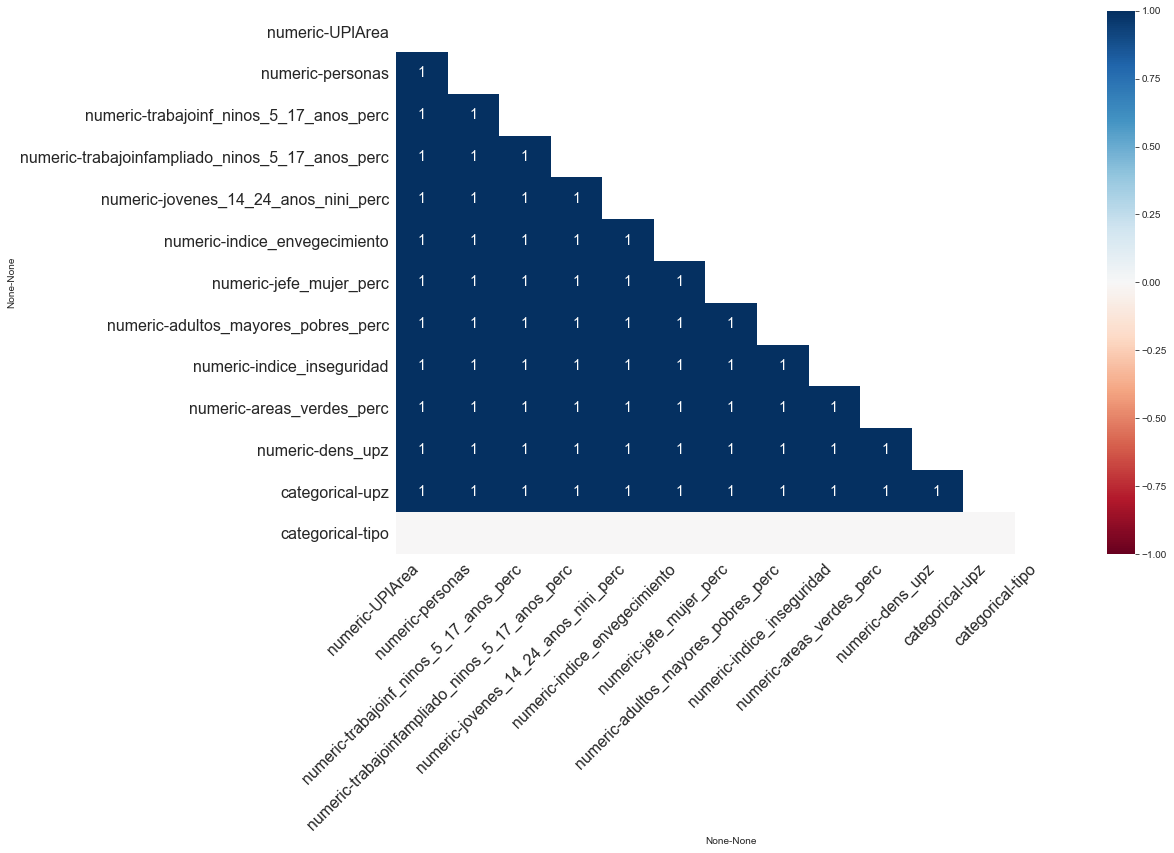

In [47]:
# Correlaciones de nulidad entre pares de variables
fig, ax = plt.subplots(figsize=[15, 10])
msno.heatmap(df, ax=ax)

In [48]:
largest_nulls = df.isnull().sum().nlargest(20)

In [49]:
nulls = df[largest_nulls.index]

In [50]:
nulls

categorical       numeric                                            \
             tipo       UPlArea  personas trabajoinf_ninos_5_17_anos_perc   
0             NaN  2.357008e+06   19451.0                             0.6   
1               1           NaN       NaN                             NaN   
2               1  4.964574e+06  179732.0                             0.4   
3             NaN  3.732645e+06  156375.0                             1.1   
4               1  2.906631e+06   50037.0                             1.8   
...           ...           ...       ...                             ...   
16276         NaN  5.598956e+06  188751.0                             1.2   
16277           6  2.060243e+06   22440.0                             0.2   
16278           6  4.224476e+06   52951.0                             0.0   
16279           8  4.224476e+06   52951.0                             0.0   
16280           8  4.586983e+06  115124.0                             1.5   

                                                                            \
      trabajoinfampliado_ninos_5_17_anos_perc jovenes_14_24_anos_nini_perc   
0                                        18.4                          7.2   
1                                         NaN                          NaN   
2                                         1.2                         14.5   
3                                         0.8                         12.6   
4                                        16.7                          9.1   
...                                       ...                          ...   
16276                                     3.9                         21.0   
16277                                     9.3                         16.7   
16278                                    17.0                          4.3   
16279                                    17.0                          4.3   
16280                                     2.0                          5.2   

                                                                         \
      indice_envegecimiento jefe_mujer_perc adultos_mayores_pobres_perc   
0                     145.7       44.896230                    5.281135   
1                       NaN             NaN                         NaN   
2                      45.4       31.113458                   14.928786   
3                      71.1       37.073314                    8.406360   
4                      54.7       36.279630                    5.420442   
...                     ...             ...                         ...   
16276                  16.9       35.008129                   18.899097   
16277                  91.2       40.729156                   16.182676   
16278                 153.4       44.667815                    5.401917   
16279                 153.4       44.667815                    5.401917   
16280                 127.3       38.443910                    3.840225   

                                                     categorical    numeric  \
      indice_inseguridad areas_verdes_perc  dens_upz         upz      price   
0               3.629032          6.563105  0.008252      UPZ101  1050000.0   
1                    NaN               NaN       NaN         NaN  3930000.0   
2               0.310559         21.756250  0.036203       UPZ75   750000.0   
3               1.029160         37.852289  0.041894       UPZ29  3400000.0   
4               3.166227         32.395663  0.017215       UPZ12  1560000.0   
...                  ...               ...       ...         ...        ...   
16276           1.628664         35.622693  0.033712       UPZ69  2600000.0   
16277           3.383459         18.205454  0.010892       UPZ94  2350000.0   
16278           2.047782         20.901367  0.012534       UPZ97  1750000.0   
16279           2.047782         20.901367  0.012534       UPZ97  3900000.0   
16280           1.161103         25.466350  0.025098       UPZ16 

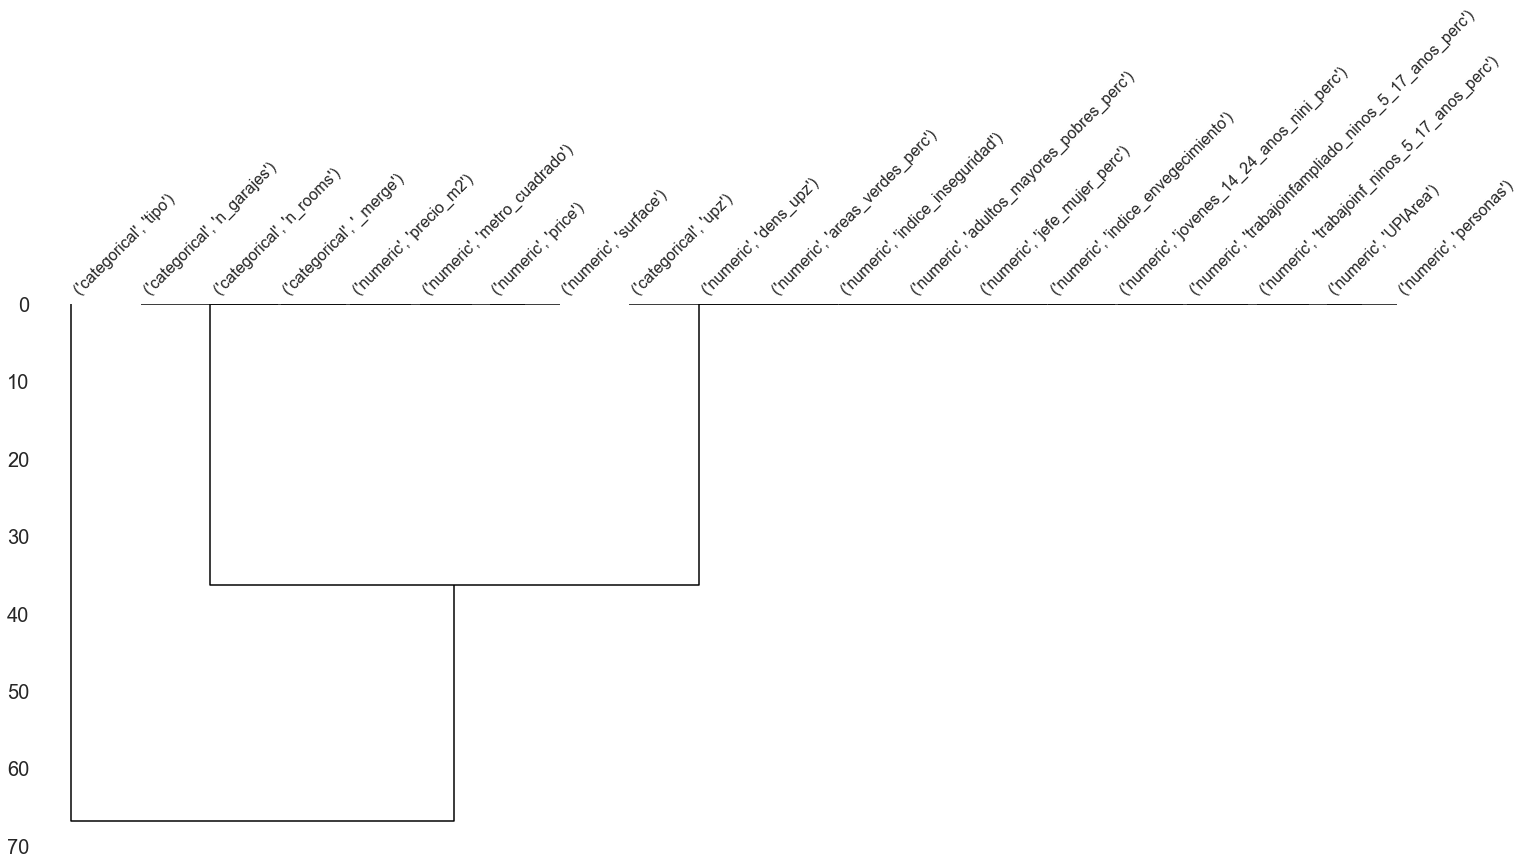

In [51]:
msno.dendrogram(nulls)

In [52]:
# dropear no mas
#f1 = df.copy()
#df1.dropna(inplace=True)

In [53]:
# dropear precio cero
# df1.drop(df1.loc[df1.numeric.precio_m2==0].index)

In [54]:
# Eliminar filas con datos faltantes que no contienen datos de UPZ, son MNAR
# creo q los tipos tambien, ya que son inclasificables

# en cambio, n_rooms baths y garajes estan todos en un cluster, esos son perdidos de otra info,
# podriamos reemplazar por ceil(promedio) o algo asi
df1 = df.copy()
df1.dropna(inplace=True)

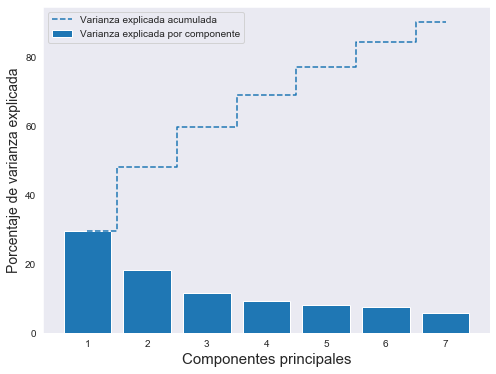

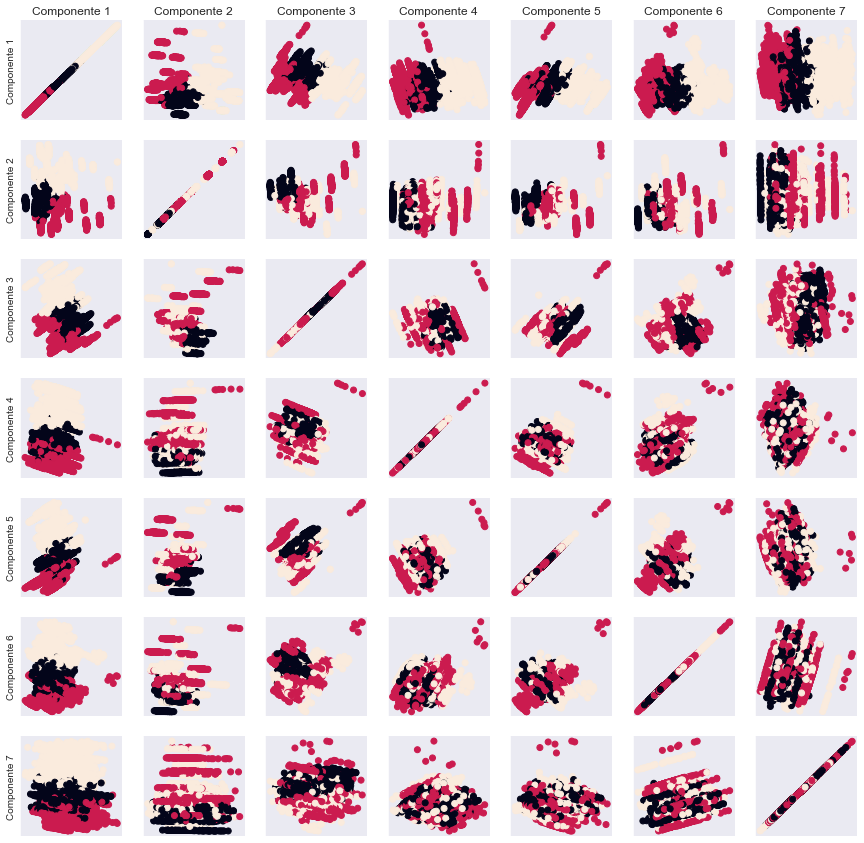

In [55]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_1 = scaler.fit_transform(
    df1['numeric'].drop(columns=['price', 'precio_m2']))


n_com = 7
pca = PCA(n_components=n_com)
pecea = pca.fit_transform(df_1)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
cum_var_exp = np.cumsum(per_var)
plt.rcParams["figure.figsize"] = [8.0, 6.0]
# the following code makes a fancy looking plot using PC1 and PC2
plt.bar(x=range(1, len(per_var)+1), height=per_var,
        label='Varianza explicada por componente')
plt.step(np.arange(n_com)+1, cum_var_exp, where='mid',
         linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada', fontsize=14)
plt.xlabel('Componentes principales', fontsize=15)
plt.legend(loc='best')
plt.show()


n_clu = 3
kmeans = KMeans(n_clusters=n_clu).fit_predict(pecea)


fig, axes = plt.subplots(n_com, n_com, figsize=(15, 15))
fig.suptitle('')

for i in range(n_com):
    for j in range(n_com):
        axes[i, j].scatter(pecea[:, i], pecea[:, j], c=kmeans)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        estilo()
        if i == 0:
            axes[i, j].set_title('Componente '+str(j+1))
        if j == 0:
            axes[i, j].set(ylabel='Componente '+str(i+1))

plt.show()

In [56]:
df = df1

In [57]:
# Evaluar como se distribuyen los upz's en esos clusters
# cuantos hay
print('hay ', len(df.categorical.upz.unique()), ' diferentes upz')
# agregar cluster
# df1.loc['categorical','upz_cluster']=kmeans
print(df1.shape)
print(kmeans.shape)

df[('categorical', 'upz_cluster')] = kmeans

hay  96  diferentes upz
(11227, 23)
(11227,)


In [58]:
df

numeric                                                               \
           price surface metro_cuadrado     precio_m2       UPlArea  personas   
2       750000.0    90.0           12.2   8333.333333  4.964574e+06  179732.0   
4      1560000.0    96.0           47.1  16250.000000  2.906631e+06   50037.0   
9      1400000.0   100.0           33.3  14000.000000  7.565953e+06   93195.0   
10     1393000.0    90.0           52.9  15477.777778  7.565953e+06   93195.0   
12     2700000.0    90.0           55.9  30000.000000  4.926920e+06  115124.0   
...          ...     ...            ...           ...           ...       ...   
16275  2750000.0    57.0           81.1  48245.614035  4.224476e+06   52951.0   
16277  2350000.0    43.0           56.0  54651.162791  2.060243e+06   22440.0   
16278  1750000.0    48.0           39.4  36458.333333  4.224476e+06   52951.0   
16279  3900000.0   102.0           51.6  38235.294118  4.224476e+06   52951.0   
16280  2525000.0   106.0           44.4  23820.754717  4.586983e+06  115124.0   

                                                                               \
      trabajoinf_ninos_5_17_anos_perc trabajoinfampliado_ninos_5_17_anos_perc   
2                                 0.4                                     1.2   
4                                 1.8                                    16.7   
9                                 1.3                                    32.0   
10                                1.3                                    32.0   
12                                1.5                                     2.0   
...                               ...                                     ...   
16275                             0.0                                    17.0   
16277                             0.2                                     9.3   
16278                             0.0                                    17.0   
16279                             0.0                                    17.0   
16280                             1.5                                     2.0   

                                                          ...            \
      jovenes_14_24_anos_nini_perc indice_envegecimiento  ...  dens_upz   
2                             14.5                  45.4  ...  0.036203   
4                              9.1                  54.7  ...  0.017215   
9                              7.7                  90.0  ...  0.012318   
10                             7.7                  90.0  ...  0.012318   
12                             5.2                 127.3  ...  0.023366   
...                            ...                   ...  ...       ...   
16275                          4.3                 153.4  ...  0.012534   
16277                         16.7                  91.2  ...  0.010892   
16278                          4.3                 153.4  ...  0.012534   
16279                          4.3                 153.4  ...  0.012534   
16280                          5.2                 127.3  ...  0.025098   

      categorical                                                     \
           _merge n_rooms n_garajes n_bath    upz tipo property_type   
2       left_only     3.0         0    1.0  UPZ75    1          Casa   
4       left_only     4.0         1    3.0  UPZ12    1          Casa   
9       left_only     4.0         1    2.0  UPZ24    1          Casa   
10      left_only     3.0         1    3.0  UPZ24    1          Casa   
12      left_only     2.0         1    2.0  UPZ14    1          Casa   
...           ...     ...       ...    ...    ...  ...           ...   
16275        both     1.0         1    2.0  UPZ97    6   Apartamento   
16277  right_only     1.0         1    1.0  UPZ94    6   Apartamento   
16278  right_only     1.0         1    1.0  UPZ97    6   Apartamento   
16279  right_only     2.0         2    3.0  UPZ97    8   Apartamento   
16280  right_only     2.0         2    3.0  UPZ16    8   Apar

In [59]:
upz_assignment = {upz: 0 for upz in df.categorical.upz.unique()}
for upz in df.categorical.upz.unique():
    cluster_aparition = []
    for k in np.arange(n_clu):
        s = sum((df.categorical.upz == upz) & (
            df1.categorical.upz_cluster == k))
        cluster_aparition.append(s)
    upz_assignment[upz] = cluster_aparition.index(max(cluster_aparition))

column = []
for upz in df.categorical.upz:
    column.append(upz_assignment[upz])
df[('categorical', 'upz_group')] = column

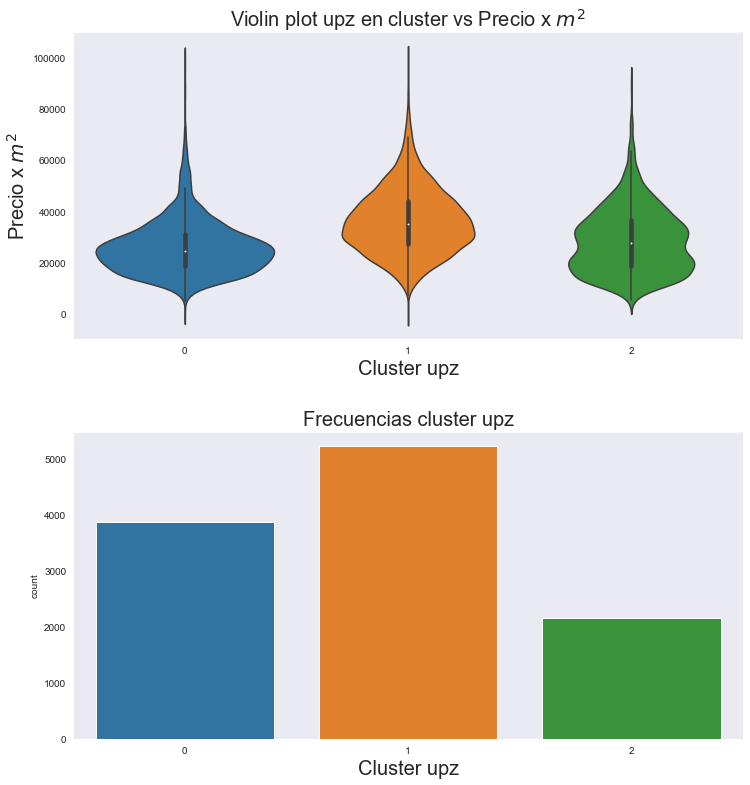

In [60]:
def violin_and_frec_plot(categorical_variable, title1, title2):
    fontdict = {'fontsize': 20}
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    sns.violinplot(('categorical', categorical_variable),
                   y=('numeric', 'precio_m2'),
                   data=df,
                   kind='violin',
                   ax=ax[0])
    sns.countplot(df[('categorical', categorical_variable)], ax=ax[1])
    ax[0].set_xlabel('Cluster upz', fontdict)
    ax[1].set_xlabel('Cluster upz', fontdict)
    # ax[0].set_ylim(0,1000000)
    ax[0].set_ylabel(r'Precio x $m^2$', fontdict)
    ax[0].set_title(title1, fontdict)
    ax[1].set_title(title2, fontdict)
    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)


violin_and_frec_plot(
    'upz_group', 'Violin plot upz en cluster vs Precio x $m^2$', 'Frecuencias cluster upz')

In [61]:
df['categorical','upz_group']

2        2
4        0
9        0
10       0
12       0
        ..
16275    1
16277    1
16278    1
16279    1
16280    0
Name: (categorical, upz_group), Length: 11227, dtype: int64

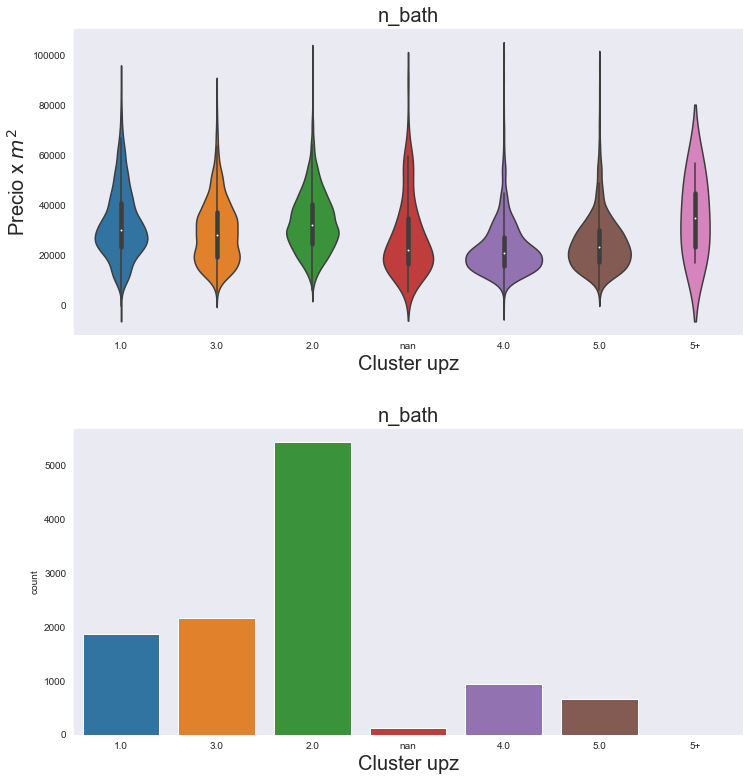

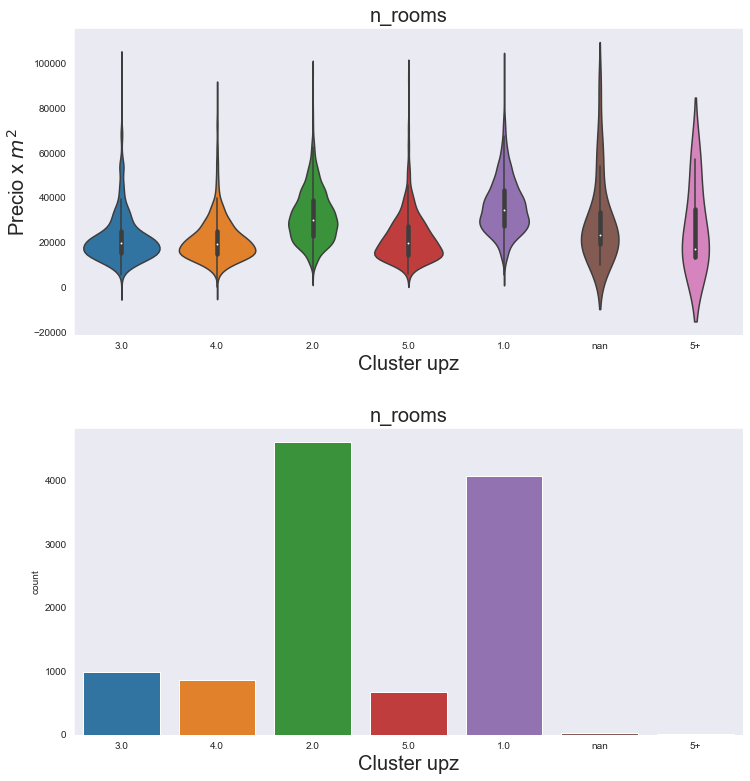

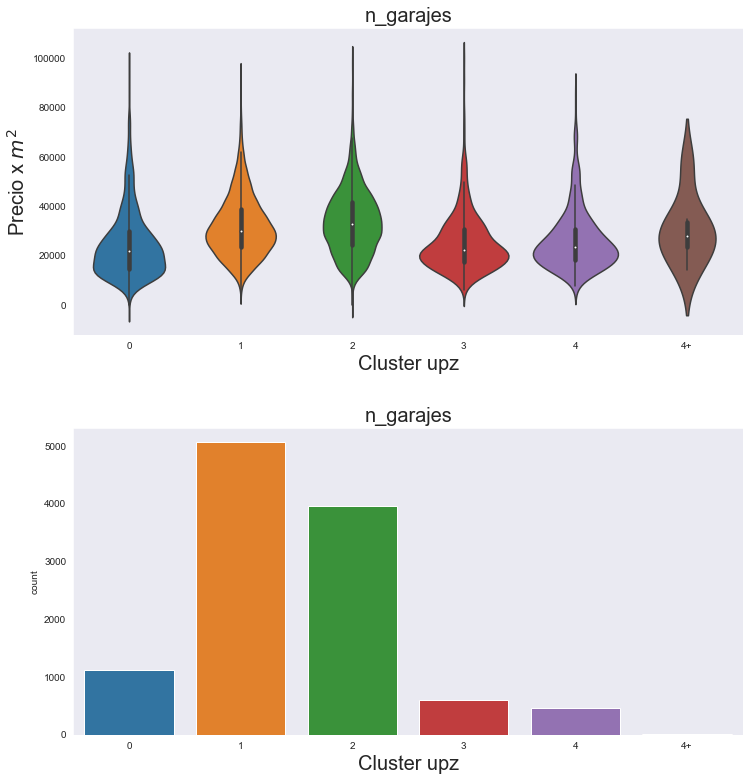

In [78]:
violin_and_frec_plot('n_bath', 'n_bath', 'n_bath')
violin_and_frec_plot('n_rooms', 'n_rooms', 'n_rooms')
violin_and_frec_plot('n_garajes', 'n_garajes', 'n_garajes')

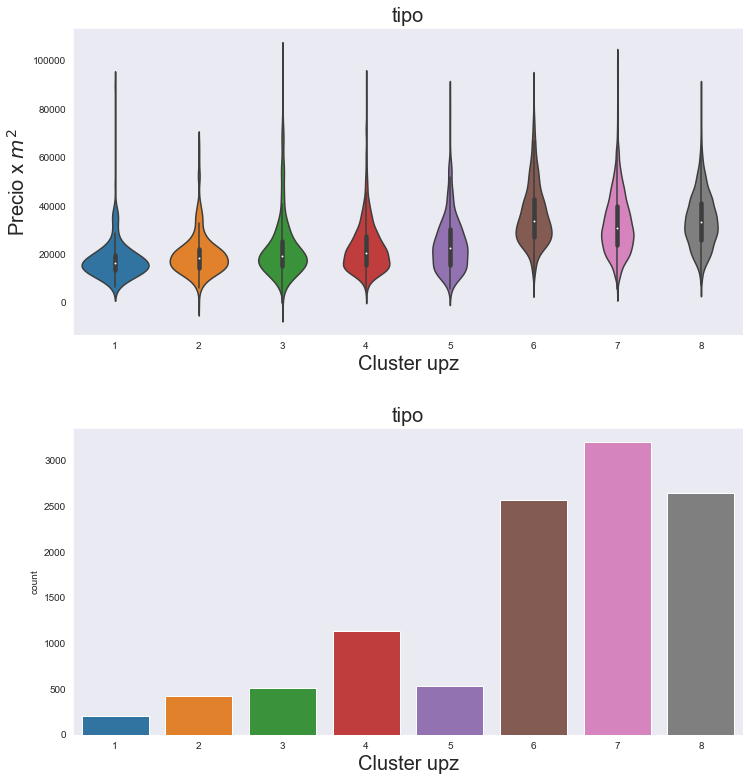

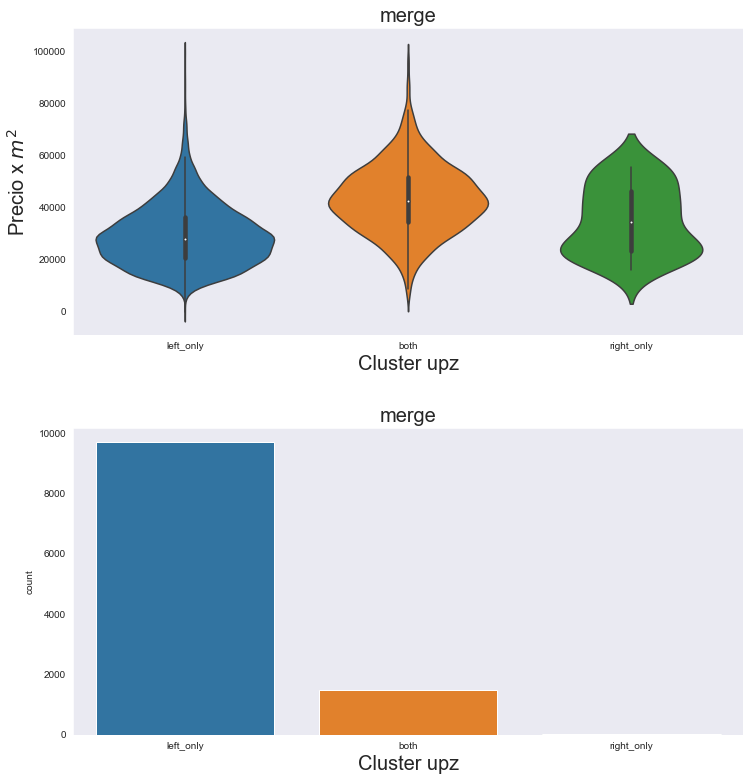

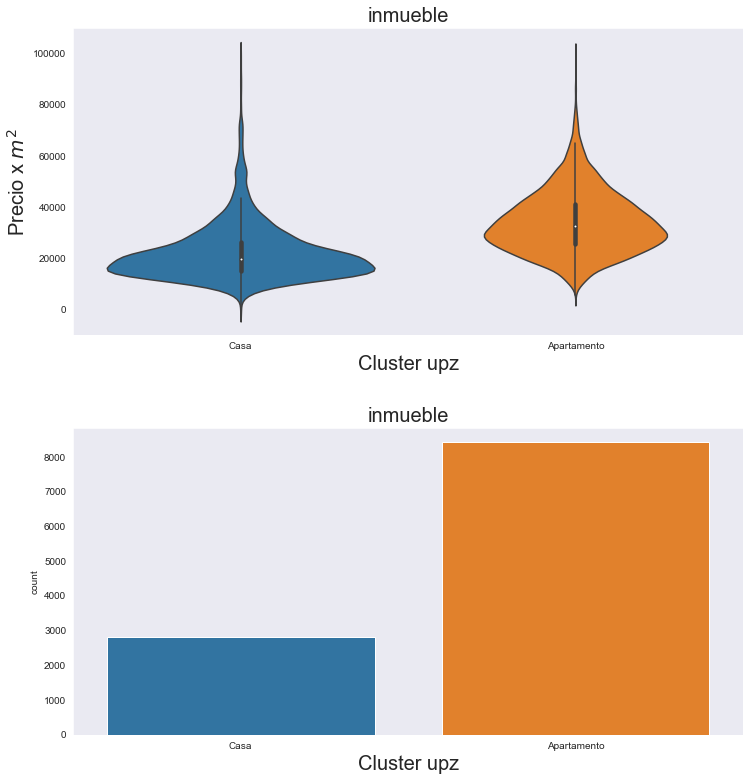

In [79]:
violin_and_frec_plot('tipo', 'tipo', 'tipo')
violin_and_frec_plot('_merge', 'merge', 'merge')
violin_and_frec_plot('property_type', 'inmueble', 'inmueble')

In [80]:
def scatter_dists(col, df=df1, h=.3, w=.1, fontdict={'fontsize': 20}, reg=True):
    ''' Recibe una columna numerica y genera una visualizacion comparativa.

    Genera una figura por sobre el dataframe HousePricing (por defecto), recibe 
    parametros extra como el espaciado entre subfigura.

    Args:
    ----------

    col: String
         El nombre de la columna numerica a visualizar

    h,w: float
        Espaciado entre subplot h -> vertical, w -> horizontal

    fontdict: dict
             Permite configurar las fuentes de los subplots
    reg: bool
         Permite graficar una regresion lineal sobre los datos (if True)

    Returns: None
        Se muestra una figura en pantalla    

    '''
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    if reg:
        sns.regplot(x=df[('numeric', col)],
                    y=df[('numeric', 'precio_m2')],
                    ax=ax[0])
        ax[0].set_title(
            r'Regplot plot {} vs Precio por m^2'.format(col), fontdict)
    else:
        sns.scatterplot(('numeric', col),
                        y=('numeric', 'precio_m2'),
                        data=df,
                        ax=ax[0])
        ax[0].set_title(
            r'Scatter plot {} vs Precio por m^2'.format(col), fontdict)

    # Distribucion univariada
    sns.distplot(df[('numeric', col)], ax=ax[1])
    ax[0].set_ylim(0, 100000)
    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('Precio por m^2', fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    plt.subplots_adjust(wspace=w, hspace=h)

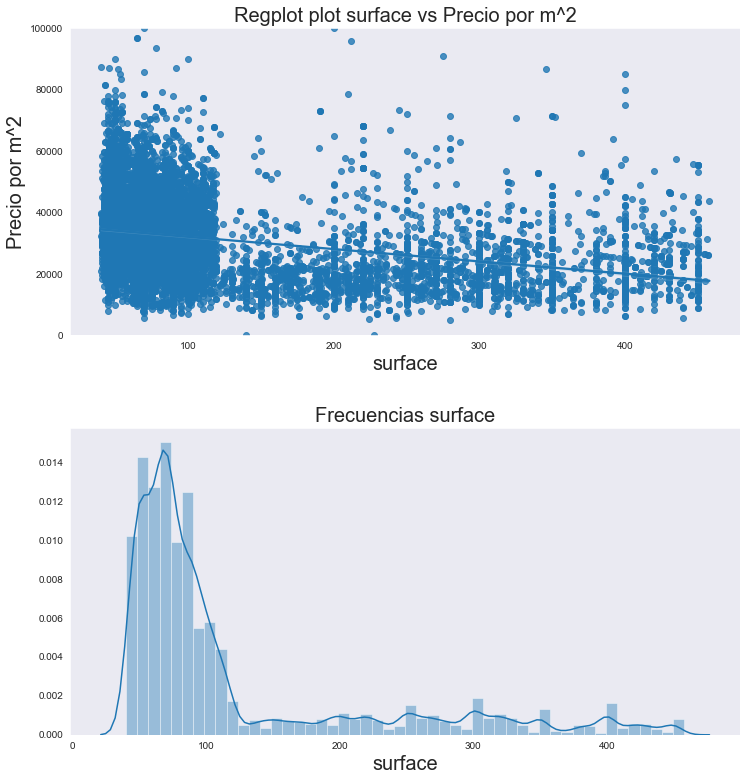

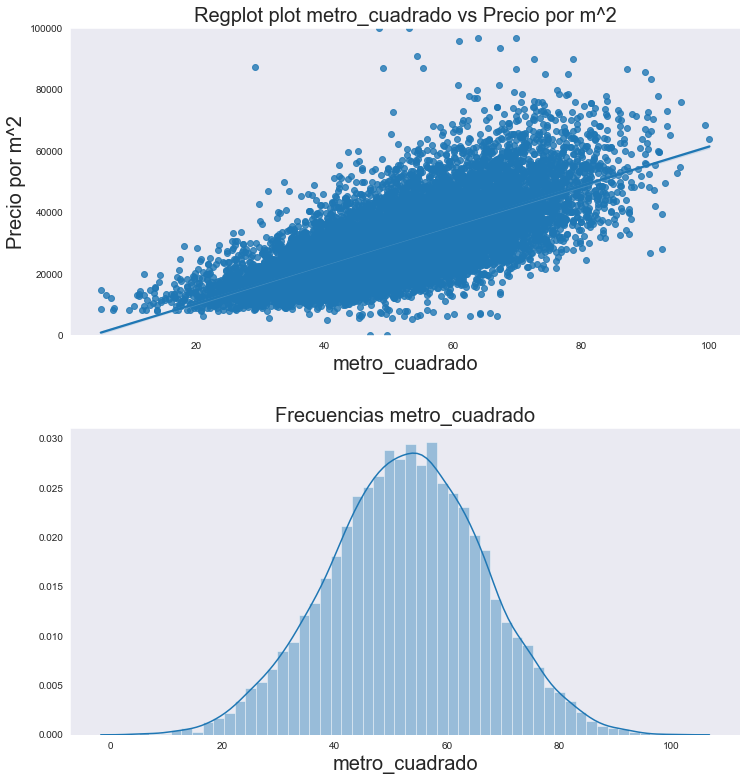

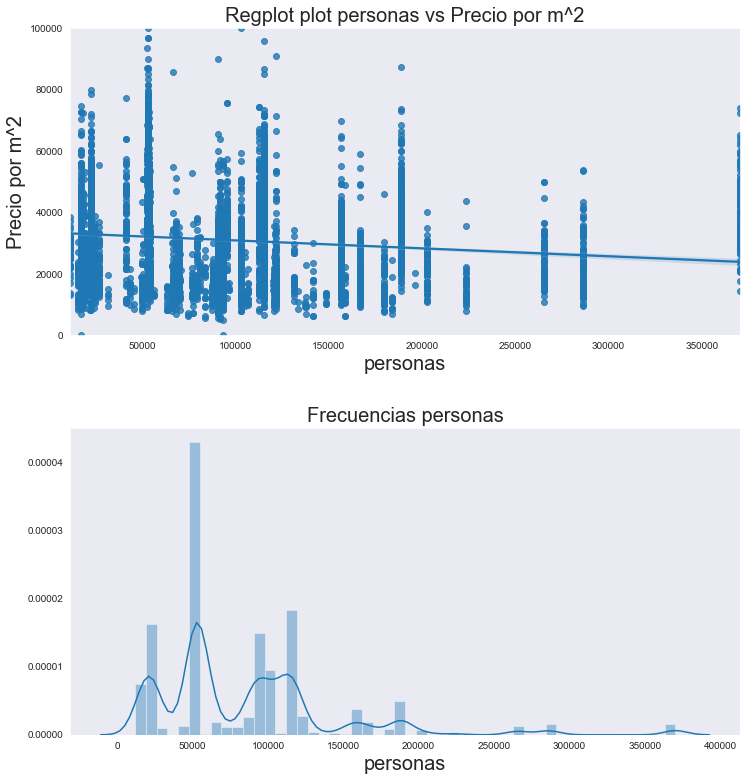

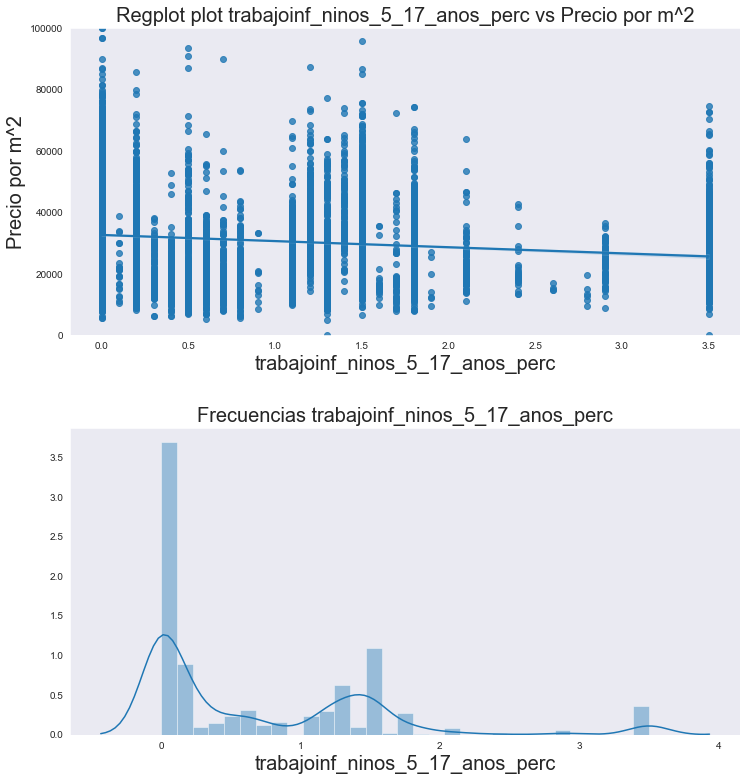

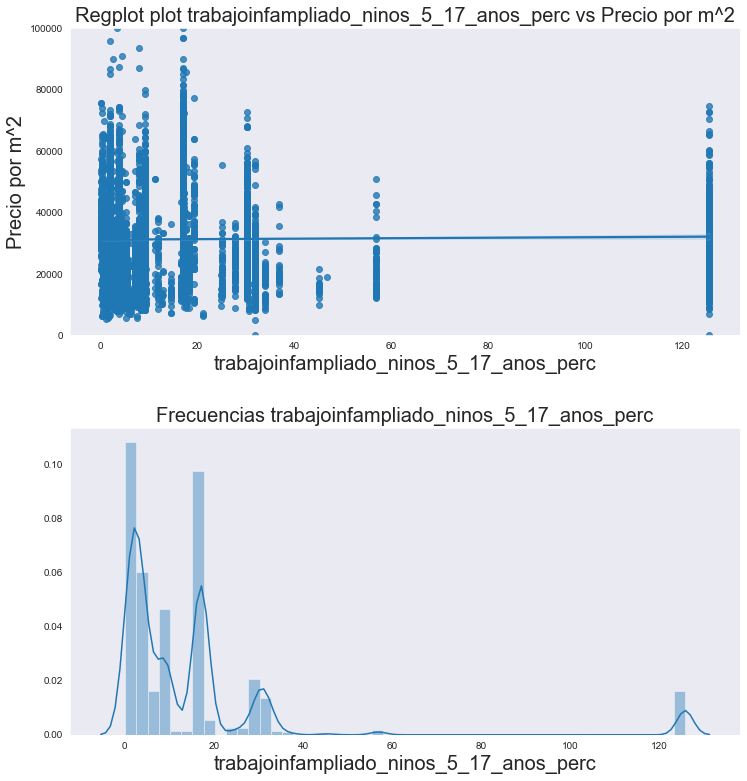

In [81]:
# scatter_dists('n_rooms')
# scatter_dists('n_bath')
scatter_dists('surface')
scatter_dists('metro_cuadrado')
# scatter_dists('n_garajes')
scatter_dists('personas')
scatter_dists('trabajoinf_ninos_5_17_anos_perc')
scatter_dists('trabajoinfampliado_ninos_5_17_anos_perc')

In [82]:
df[('categorical', 'upz_group')].unique()

array([2, 0, 1], dtype=int64)

In [83]:
# Perfilamiento Bivariado
# Se genera una función auxiliar


def indexer(cols, t_c=df1.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''

    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    return tuples


def perfil_bivariado(interest):
    # Variables a examinar
    idxs = indexer(interest)
    df1[idxs].head()
    # Pone precio_m2 al final de la lista
    idxs.sort()
    idxs.remove(('numeric', 'precio_m2'))
    idxs.append(('numeric', 'precio_m2'))
    # para que Seaborn entienda
    data = df1.reindex(idxs, axis=1).droplevel(0, axis=1)
    # quitar 100 datos con precio mas grande para poder visualizar mejor
    data.drop(data.precio_m2.nlargest(100).index)

    sns.pairplot(data=data, diag_kind='kde')

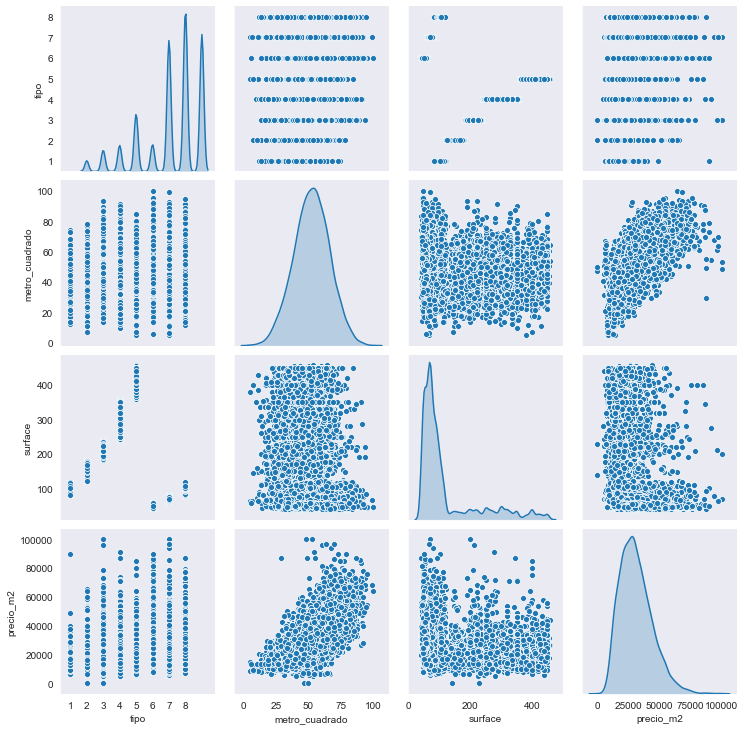

In [84]:
#interest1=['precio_m2', 'n_rooms', 'n_bath', 'surface', 'n_garajes','property_type', 'upz_group','tipo','metro_cuadrado']
interest1 = ['precio_m2', 'n_rooms', 'n_bath', 'surface',
             'n_garajes', 'property_type', 'tipo', 'metro_cuadrado']
perfil_bivariado(interest1)

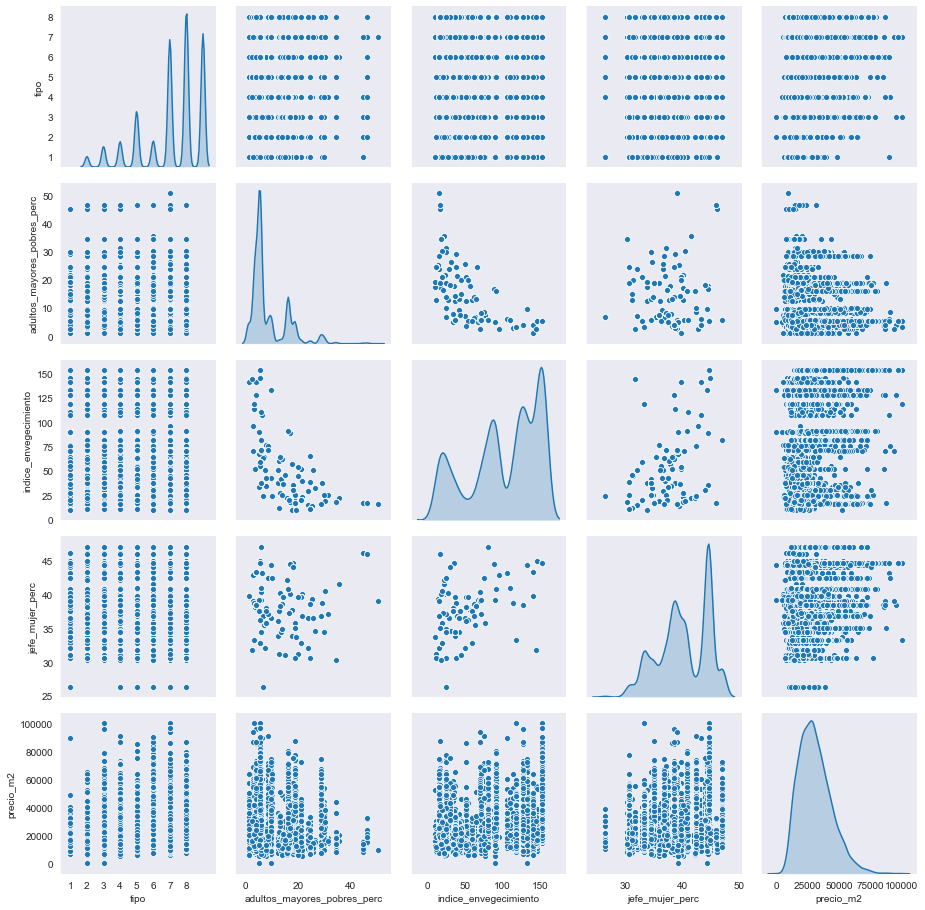

In [85]:
interest2 = ['precio_m2', 'jefe_mujer_perc',
             'indice_envegecimiento', 'adultos_mayores_pobres_perc', 'tipo']
perfil_bivariado(interest2)

10 variables más correlacionadas
                                                      numeric
                                                    precio_m2
numeric     precio_m2                                1.000000
            metro_cuadrado                           0.680506
            jefe_mujer_perc                          0.353681
            indice_envegecimiento                    0.306006
            price                                    0.239256
categorical upz_cluster                              0.144283
            upz_group                                0.140369
numeric     trabajoinfampliado_ninos_5_17_anos_perc  0.014706
            indice_inseguridad                       0.005989
            UPlArea                                 -0.023939
3 variables menos correlacionadas
                                       numeric
                                     precio_m2
numeric surface                      -0.307283
        dens_upz                     -0.178741
 

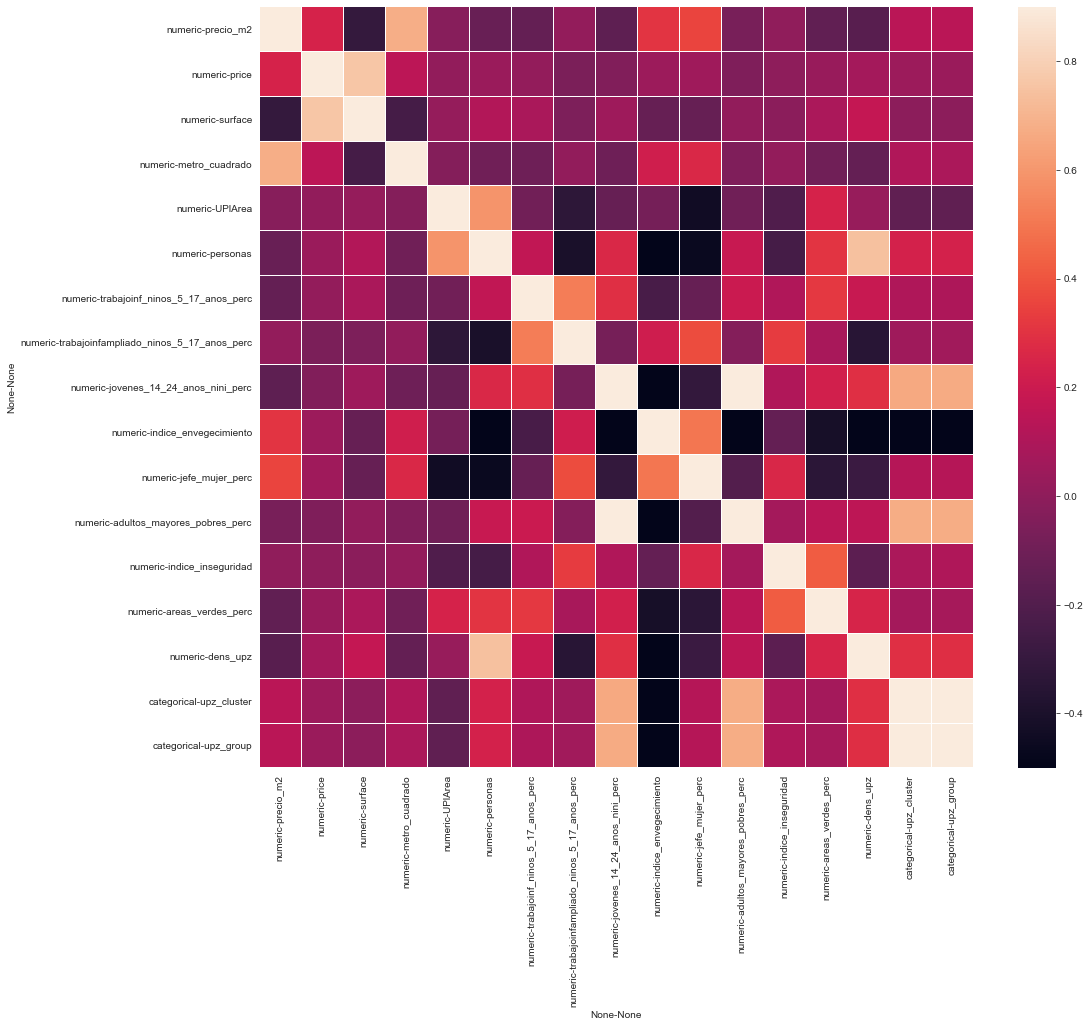

In [86]:
# matriz de correlaciones
corr_matrix = df1.corr()
col = indexer(['precio_m2'])
print('10 variables más correlacionadas')
print(corr_matrix[col].nlargest(10, col))
print('3 variables menos correlacionadas')
print(corr_matrix[col].nsmallest(3, col))


# Visualizar

'''
Se inserta 'precio_m2' como primera fila x columna de la matriz de correlacion
'''

unsorted = list(corr_matrix.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corr_matrix.reindex(index=sortd, columns=sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [87]:
# analisis categórico versus categóricos

data_cat = df1['categorical']


def categorical_compa(cat1, cat2):
    to_compare = [cat1, cat2]
    kwargs = {'index': data_cat[to_compare[0]],
              'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
    return tabla

In [88]:
categorical_compa('rent_type', 'property_type')

property_type,Apartamento,Casa,Total
rent_type,,,
Arriendo,7345,2161,9506
Venta Y Arriendo,1080,641,1721
Total,8425,2802,11227


In [89]:
categorical_compa('rent_type', 'tipo')

tipo,1,2,3,4,5,6,7,8,Total
rent_type,,,,,,,,,
Arriendo,194,363,393,827,384,2333,2811,2201,9506
Venta Y Arriendo,12,57,117,308,147,241,392,447,1721
Total,206,420,510,1135,531,2574,3203,2648,11227


In [90]:
#categorical_compa('tipo', 'zona')

In [91]:
categorical_compa('upz_group', 'tipo')

tipo,1,2,3,4,5,6,7,8,Total
upz_group,,,,,,,,,
0,113,241,268,544,213,803,1100,583,3865
1,31,81,115,263,135,1358,1594,1640,5217
2,62,98,127,328,183,413,509,425,2145
Total,206,420,510,1135,531,2574,3203,2648,11227


In [92]:
# comparar con test xi^2
from scipy.stats import chi2_contingency


def test_xi(cat1, cat2):
    to_compare = [cat1, cat2]
    kwargs = {'index': data_cat[to_compare[0]],
              'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex = chi2_contingency(tabla)
    expected_freq = pd.DataFrame(ex, index=df1.categorical[cat1].unique())
    expected_freq.index.name = cat1
    expected_freq.columns.name = cat2
    return p, expected_freq


p, table = test_xi('upz_group', 'tipo')
print(p)
print(p <= 0.05)
table

1.0124744421709196e-213
True


tipo,0,1,2,3,4,5,6,7
upz_group,,,,,,,,
2,70.917431,144.588937,175.572281,390.734390,182.801728,886.123631,1102.662777,911.598824
0,95.724771,195.167008,236.988510,527.415605,246.746860,1196.094950,1488.380778,1230.481518
1,39.357798,80.244055,97.439209,216.850004,101.451412,491.781420,611.956444,505.919658


In [93]:
p, table = test_xi('rent_type', 'tipo')
print(p)
print(p <= 0.05)
table

1.5118920977302235e-65
True


tipo,0,1,2,3,4,5,6,7
rent_type,,,,,,,,
Arriendo,174.422018,355.617707,431.821502,961.014519,449.602387,2179.428521,2712.008373,2242.084974
Venta Y Arriendo,31.577982,64.382293,78.178498,173.985481,81.397613,394.571479,490.991627,405.915026


# P3

### Implementación. 1

In [115]:
from sklearn.base import BaseEstimator, RegressorMixin
from numpy import matmul
from numpy.linalg import pinv, eig
import sys
import time
import numpy as np


class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):
    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.maxiter = maxiter
        self.tol = tol
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.alpha = alpha_0
        self.beta = beta_0
        self.M_n = None
        self.S_n = None

    def get_posteriori(self, X, y, alpha, beta):

        S_n = alpha + beta*matmul(X.T, X)
        M_n = beta * matmul(matmul(pinv(S_n), X.T), y)
        return M_n, S_n

    def fit(self, X, y):
        X = np.hstack((np.ones((1, X.shape[0])).T, X))
        N = len(y)
        for i in range(self.maxiter):
            t0 = time.time()
            eigen_values, _ = eig(self.beta * matmul(X.T, X))
            eigen_values = np.real_if_close(eigen_values)
            gamma = (eigen_values/(self.alpha + eigen_values)).sum()
            M_n, S_n = self.get_posteriori(X, y, self.alpha, self.beta)
            new_alpha = gamma/(matmul(M_n.T, M_n))
            new_beta = (N-gamma)/((y - matmul(M_n.T, X.T))
                                  ** 2).sum()  # Revisar X.T

            alpha_delta = np.abs(self.alpha - new_alpha)
            beta_delta = np.abs(self.beta - new_beta)

            sys.stdout.write(
                '\rIteracion:{0:03d} '.format(
                    i+1) + '| Alpha :{0:.5f} '.format(new_alpha)
                + '| Beta :{0:.5f} '.format(new_beta)
                + '| Tiempo/iter:{0:.5f}s'.format(time.time() - t0)
            )

            if (alpha_delta > self.tol or beta_delta > self.tol):
                self.alpha = new_alpha
                self.beta = new_beta
            else:
                self.M_n = M_n
                self.S_n = S_n
                break
        self.M_n = M_n
        self.S_n = S_n

    # Predicción utilizando la media posterior predictiva
    def predict(self, X_, return_std=False):
        X_ = np.hstack((np.ones((1, X_.shape[0])).T, X_))
        mu = matmul(self.M_n.T, X_.T)
        if return_std:
            std = np.sqrt(self.beta**-1 + matmul(matmul(X_.T, self.S_n), X_))
            return mu, std
        else:
            return mu

In [133]:
numeric = [tupla[1] for tupla in df1.columns
           if tupla[0] == 'numeric' and
           tupla[1] != 'precio_m2' and tupla[1]!= 'price']

categorical = [tupla[1] for tupla in df1.columns
               if tupla[0] == 'categorical'
               and tupla[1] != '_merge'
               and tupla[1] != 'url'
               and tupla[1] != 'location'
               and tupla[1] != 'details'
               and tupla[1] != 'upz_cluster']

In [134]:
numeric

['surface',
 'metro_cuadrado',
 'UPlArea',
 'personas',
 'trabajoinf_ninos_5_17_anos_perc',
 'trabajoinfampliado_ninos_5_17_anos_perc',
 'jovenes_14_24_anos_nini_perc',
 'indice_envegecimiento',
 'jefe_mujer_perc',
 'adultos_mayores_pobres_perc',
 'indice_inseguridad',
 'areas_verdes_perc',
 'dens_upz']

In [135]:
categorical

['n_rooms',
 'n_garajes',
 'n_bath',
 'upz',
 'tipo',
 'property_type',
 'rent_type',
 'upz_group']

In [136]:
X = df1.reindex(df1.columns, axis=1).droplevel(0, axis=1)
y = df1['numeric']['precio_m2']

In [137]:
from sklearn.model_selection import train_test_split
seed = 3891624866
seed = 0

np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(y), test_size=0.2)

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                      #('StandarScaler', StandardScaler()),
                                      ('MinMaxScaler', MinMaxScaler()),
                                      ('PolynomialFeatures', PolynomialFeatures(degree=3))])


categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Nan')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric),
                                               ('cat', categorical_transformer, categorical)])


regressor = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RegresionBayesianaEmpirica(
                                alpha_0=1e-8, beta_0=1e-8, tol=1e-14, maxiter=300))])


regressor.fit(X_train, y_train)

Iteracion:005| Alpha :0.00000 | Beta :0.00000 | Tiempo/iter:0.79213s

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [139]:
from sklearn.metrics import r2_score, mean_squared_error

Y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred, squared=False)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

   RMSE: 8300.693
R2Score: 0.559


Guardamos el modelo

In [140]:
import pickle
filename = '0445.sav'
#pickle.dump(regressor, open(filename, 'wb'))

In [141]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, y_train)
print(result)

0.9855102678128704


Bayesian Ridge regression

In [142]:
from sklearn.linear_model import BayesianRidge
c = 1e-08

bayesian_ridge_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', BayesianRidge(alpha_1=c,
                                                                        alpha_2=c,
                                                                        lambda_1=c,
                                                                        lambda_2=c))])
bayesian_ridge_regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

In [143]:
Y_pred = bayesian_ridge_regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred, squared=True)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

   RMSE: 56175833.277
R2Score: 0.641
